In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from ComputationalGraphPrimer import *
import operator
from numpy import nan

In [2]:
class SGDPlus(ComputationalGraphPrimer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        
    def run_training_loop_multi_neuron_model(self, training_data,mu=0.0,SGDplus=False):

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                


        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.
        
        ##My input start
        self.bias_update = [0.0]*(self.num_layers+1)
        self.step = [[0]*(len(self.learnable_params)+1)]*(self.num_layers+1)
        self.mu = mu if SGDplus else 0.0      
        
        ##My input end
        
        
        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_error_avg, class_labels)      ## BACKPROP loss
        return loss_running_record
           


    def forward_prop_multi_neuron_model(self, data_tuples_in_batch):
        """
        During forward propagation, we push each batch of the input data through the
        network.  In order to explain the logic of forward, consider the following network
        layout in 4 nodes in the input layer, 2 nodes in the hidden layer, and 1 node in
        the output layer.

                               input
                                  
                                 x                                             x = node
                                                                            
                                 x         x|                                  | = sigmoid activation
                                                     x|
                                 x         x|   

                                 x
                            
                             layer_0    layer_1    layer_2

                
        In the code shown below, the expressions to evaluate for computing the
        pre-activation values at a node are stored at the layer in which the nodes reside.
        That is, the dictionary look-up "self.layer_exp_objects[layer_index]" returns the
        Expression objects for which the left-side dependent variable is in the layer
        pointed to layer_index.  So the example shown above, "self.layer_exp_objects[1]"
        will return two Expression objects, one for each of the two nodes in the second
        layer of the network (that is, layer indexed 1).

        The pre-activation values obtained by evaluating the expressions at each node are
        then subject to Sigmoid activation, followed by the calculation of the partial
        derivative of the output of the Sigmoid function with respect to its input.

        In the forward, the values calculated for the nodes in each layer are stored in
        the dictionary

                        self.forw_prop_vals_at_layers[ layer_index ]

        and the gradients values calculated at the same nodes in the dictionary:

                        self.gradient_vals_for_layers[ layer_index ]

        """
        self.forw_prop_vals_at_layers = {i : [] for i in range(self.num_layers)}   
        self.gradient_vals_for_layers = {i : [] for i in range(1, self.num_layers)}
        for vals_for_input_vars in data_tuples_in_batch:
            self.forw_prop_vals_at_layers[0].append(vals_for_input_vars)
            for layer_index in range(1, self.num_layers):
                input_vars = self.layer_vars[layer_index-1]
                if layer_index == 1:
                    vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
                output_vals_arr = []
                gradients_val_arr = []
                ##  In the following loop for forward propagation calculations, exp_obj is the Exp object
                ##  that is created for each user-supplied expression that specifies the network.  See the
                ##  definition of the class Exp (for 'Expression') by searching for "class Exp":
                for exp_obj in self.layer_exp_objects[layer_index]:
                    output_val = self.eval_expression(exp_obj.body , vals_for_input_vars_dict,    
                                                                 self.vals_for_learnable_params, input_vars)
                    ## [Search for "self.bias" in this file.]  As mentioned earlier, adding bias to each 
                    ##  layer improves class discrimination:
                    output_val = output_val + self.bias[layer_index-1]                
                    ## apply sigmoid activation:
                    output_val = 1.0 / (1.0 + np.exp(-1.0 * output_val))
                    output_vals_arr.append(output_val)
                    ## calculate partial of the activation function as a function of its input
                    deriv_sigmoid = output_val * (1.0 - output_val)
                    gradients_val_arr.append(deriv_sigmoid)
                    vals_for_input_vars_dict[ exp_obj.dependent_var ] = output_val
                self.forw_prop_vals_at_layers[layer_index].append(output_vals_arr)
                ##  See the bullets in red on Slides 70 and 73 of my Week 3 slides for what needs
                ##  to be stored during the forward propagation of data through the network:
                self.gradient_vals_for_layers[layer_index].append(gradients_val_arr)


    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels):
        """
        First note that loop index variable 'back_layer_index' starts with the index of
        the last layer.  For the 3-layer example shown for 'forward', back_layer_index
        starts with a value of 2, its next value is 1, and that's it.

        Stochastic Gradient Gradient calls for the backpropagated loss to be averaged over
        the samples in a batch.  To explain how this averaging is carried out by the
        backprop function, consider the last node on the example shown in the forward()
        function above.  Standing at the node, we look at the 'input' values stored in the
        variable "input_vals".  Assuming a batch size of 8, this will be list of
        lists. Each of the inner lists will have two values for the two nodes in the
        hidden layer. And there will be 8 of these for the 8 elements of the batch.  We average
        these values 'input vals' and store those in the variable "input_vals_avg".  Next we
        must carry out the same batch-based averaging for the partial derivatives stored in the
        variable "deriv_sigmoid".

        Pay attention to the variable 'vars_in_layer'.  These store the node variables in
        the current layer during backpropagation.  Since back_layer_index starts with a
        value of 2, the variable 'vars_in_layer' will have just the single node for the
        example shown for forward(). With respect to what is stored in vars_in_layer', the
        variables stored in 'input_vars_to_layer' correspond to the input layer with
        respect to the current layer. 
        """
        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                ##  Regarding the parameter update loop that follows, see the Slides 74 through 77 of my Week 3 
                ##  lecture slides for how the parameters are updated using the partial derivatives stored away 
                ##  during forward propagation of data. The theory underlying these calculations is presented 
                ##  in Slides 68 through 71. 
                for i,param in enumerate(layer_params):
                    gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j]
                    
                    #My change start
                    self.step[back_layer_index-1][i] = (self.mu*self.step[back_layer_index-1][i]) +  gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                       
                    
                    self.vals_for_learnable_params[param] += self.step[back_layer_index-1][i]*self.learning_rate
                    
                    
            self.bias_update[back_layer_index-1] = (self.mu*self.bias_update[back_layer_index-1]) + sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                           * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)       
            self.bias[back_layer_index-1] += self.learning_rate * self.bias_update[back_layer_index-1]
            
            ##My change end
    ######################################################################################################


In [3]:
class Adam(ComputationalGraphPrimer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        
    def run_training_loop_multi_neuron_model(self, training_data,beta1,beta2):

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                


        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.
        
        ##My input start
        self.bias_m = [0.0]*(self.num_layers+1)
        self.bias_v = [0.0]*(self.num_layers+1)
        self.bias_mh = [0.0]*(self.num_layers+1)
        self.bias_vh = [0.0]*(self.num_layers+1)
        
        self.step_m = [[0]*(len(self.learnable_params)+1)]*(self.num_layers+1)
        self.step_v = [[0]*(len(self.learnable_params)+1)]*(self.num_layers+1) 
        self.step_mh = [[0]*(len(self.learnable_params)+1)]*(self.num_layers+1)
        self.step_vh = [[0]*(len(self.learnable_params)+1)]*(self.num_layers+1) 
        
        self.beta1 = beta1
        self.beta2 = beta2  
        self.m = 0
        
        ##My input end
        
        
        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            self.m = i+1
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_error_avg, class_labels)      ## BACKPROP loss
        return loss_running_record
           


    def forward_prop_multi_neuron_model(self, data_tuples_in_batch):
        """
        During forward propagation, we push each batch of the input data through the
        network.  In order to explain the logic of forward, consider the following network
        layout in 4 nodes in the input layer, 2 nodes in the hidden layer, and 1 node in
        the output layer.

                               input
                                  
                                 x                                             x = node
                                                                            
                                 x         x|                                  | = sigmoid activation
                                                     x|
                                 x         x|   

                                 x
                            
                             layer_0    layer_1    layer_2

                
        In the code shown below, the expressions to evaluate for computing the
        pre-activation values at a node are stored at the layer in which the nodes reside.
        That is, the dictionary look-up "self.layer_exp_objects[layer_index]" returns the
        Expression objects for which the left-side dependent variable is in the layer
        pointed to layer_index.  So the example shown above, "self.layer_exp_objects[1]"
        will return two Expression objects, one for each of the two nodes in the second
        layer of the network (that is, layer indexed 1).

        The pre-activation values obtained by evaluating the expressions at each node are
        then subject to Sigmoid activation, followed by the calculation of the partial
        derivative of the output of the Sigmoid function with respect to its input.

        In the forward, the values calculated for the nodes in each layer are stored in
        the dictionary

                        self.forw_prop_vals_at_layers[ layer_index ]

        and the gradients values calculated at the same nodes in the dictionary:

                        self.gradient_vals_for_layers[ layer_index ]

        """
        self.forw_prop_vals_at_layers = {i : [] for i in range(self.num_layers)}   
        self.gradient_vals_for_layers = {i : [] for i in range(1, self.num_layers)}
        for vals_for_input_vars in data_tuples_in_batch:
            self.forw_prop_vals_at_layers[0].append(vals_for_input_vars)
            for layer_index in range(1, self.num_layers):
                input_vars = self.layer_vars[layer_index-1]
                if layer_index == 1:
                    vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
                output_vals_arr = []
                gradients_val_arr = []
                ##  In the following loop for forward propagation calculations, exp_obj is the Exp object
                ##  that is created for each user-supplied expression that specifies the network.  See the
                ##  definition of the class Exp (for 'Expression') by searching for "class Exp":
                for exp_obj in self.layer_exp_objects[layer_index]:
                    output_val = self.eval_expression(exp_obj.body , vals_for_input_vars_dict,    
                                                                 self.vals_for_learnable_params, input_vars)
                    ## [Search for "self.bias" in this file.]  As mentioned earlier, adding bias to each 
                    ##  layer improves class discrimination:
                    output_val = output_val + self.bias[layer_index-1]                
                    ## apply sigmoid activation:
                    output_val = 1.0 / (1.0 + np.exp(-1.0 * output_val))
                    output_vals_arr.append(output_val)
                    ## calculate partial of the activation function as a function of its input
                    deriv_sigmoid = output_val * (1.0 - output_val)
                    gradients_val_arr.append(deriv_sigmoid)
                    vals_for_input_vars_dict[ exp_obj.dependent_var ] = output_val
                self.forw_prop_vals_at_layers[layer_index].append(output_vals_arr)
                ##  See the bullets in red on Slides 70 and 73 of my Week 3 slides for what needs
                ##  to be stored during the forward propagation of data through the network:
                self.gradient_vals_for_layers[layer_index].append(gradients_val_arr)


    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels):
        """
        First note that loop index variable 'back_layer_index' starts with the index of
        the last layer.  For the 3-layer example shown for 'forward', back_layer_index
        starts with a value of 2, its next value is 1, and that's it.

        Stochastic Gradient Gradient calls for the backpropagated loss to be averaged over
        the samples in a batch.  To explain how this averaging is carried out by the
        backprop function, consider the last node on the example shown in the forward()
        function above.  Standing at the node, we look at the 'input' values stored in the
        variable "input_vals".  Assuming a batch size of 8, this will be list of
        lists. Each of the inner lists will have two values for the two nodes in the
        hidden layer. And there will be 8 of these for the 8 elements of the batch.  We average
        these values 'input vals' and store those in the variable "input_vals_avg".  Next we
        must carry out the same batch-based averaging for the partial derivatives stored in the
        variable "deriv_sigmoid".

        Pay attention to the variable 'vars_in_layer'.  These store the node variables in
        the current layer during backpropagation.  Since back_layer_index starts with a
        value of 2, the variable 'vars_in_layer' will have just the single node for the
        example shown for forward(). With respect to what is stored in vars_in_layer', the
        variables stored in 'input_vars_to_layer' correspond to the input layer with
        respect to the current layer. 
        """
        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                ##  Regarding the parameter update loop that follows, see the Slides 74 through 77 of my Week 3 
                ##  lecture slides for how the parameters are updated using the partial derivatives stored away 
                ##  during forward propagation of data. The theory underlying these calculations is presented 
                ##  in Slides 68 through 71. 
                for i,param in enumerate(layer_params):
                    gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j]
                    
                    #My change start
                    self.step_m[back_layer_index-1][i] = (self.beta1*self.step_m[back_layer_index-1][i]) + (1-self.beta1)*(gradient_of_loss_for_param * deriv_sigmoid_avg[j])
                    self.step_mh[back_layer_index-1][i] = self.step_m[back_layer_index-1][i]/(1-(self.beta1**self.m))                    
                    self.step_v[back_layer_index-1][i] = (self.beta2*self.step_v[back_layer_index-1][i]) + (1-self.beta2)*((gradient_of_loss_for_param * deriv_sigmoid_avg[j])**2)
                    self.step_vh[back_layer_index-1][i] = self.step_v[back_layer_index-1][i]/(1-(self.beta2**self.m))                    
                    self.vals_for_learnable_params[param] += self.learning_rate * (self.step_mh[back_layer_index-1][i]/(np.sqrt(self.step_vh[back_layer_index-1][i])+10**-6))
                    
                    
            self.bias_m[back_layer_index-1] = (self.beta1*self.bias_m[back_layer_index-1]) + (1-self.beta1)*(sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                           * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg))
            self.bias_mh[back_layer_index-1] = self.bias_m[back_layer_index-1]/(1-(self.beta1**self.m))
            self.bias_v[back_layer_index-1] = (self.beta2*self.bias_v[back_layer_index-1]) + (1-self.beta2)*((sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                           * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg))**2) 
            self.bias_vh[back_layer_index-1] = self.bias_v[back_layer_index-1]/(1-(self.beta2**self.m))
            self.bias[back_layer_index-1] += self.learning_rate * (self.bias_mh[back_layer_index-1]/(np.sqrt(self.bias_vh[back_layer_index-1])+10**-6)) 
            
            ##My change end
    ######################################################################################################


In [4]:
cgp1 = SGDPlus(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 5e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp1.parse_multi_layer_expressions()
training_data1 = cgp1.gen_training_data()



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xq', 'xr', 'xs', 'xp'}


[layer index: 1] learnable params: {'aq', 'as', 'bp', 'br', 'bs', 'bq', 'ar', 'ap'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xr', 'xs', 'xq', 'xp'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xq': {'xw', 'xz'}, 'xr': {'xw', 'xz'}, 'xs': {'xw', 'xz'}, 'xp': {'xw', 'xz'}}


[layer index: 2] all variables: {'xw', 'xo', 'xz', 'xq', 'xr', 'x

In [5]:
cgp2 = Adam(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 5e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp2.parse_multi_layer_expressions()
training_data2 = cgp2.gen_training_data()



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xq', 'xr', 'xs', 'xp'}


[layer index: 1] learnable params: {'aq', 'as', 'bp', 'br', 'bs', 'bq', 'ar', 'ap'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xr', 'xs', 'xq', 'xp'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xq': {'xw', 'xz'}, 'xr': {'xw', 'xz'}, 'xs': {'xw', 'xz'}, 'xp': {'xw', 'xz'}}


[layer index: 2] all variables: {'xw', 'xo', 'xz', 'xq', 'xr', 'x

[iter=1]  loss = 0.0048
[iter=101]  loss = 0.3295
[iter=201]  loss = 0.2680
[iter=301]  loss = 0.2533
[iter=401]  loss = 0.2507
[iter=501]  loss = 0.2506
[iter=601]  loss = 0.2506
[iter=701]  loss = 0.2506
[iter=801]  loss = 0.2504
[iter=901]  loss = 0.2505
[iter=1001]  loss = 0.2506
[iter=1101]  loss = 0.2502
[iter=1201]  loss = 0.2506
[iter=1301]  loss = 0.2507
[iter=1401]  loss = 0.2507
[iter=1501]  loss = 0.2504
[iter=1601]  loss = 0.2497
[iter=1701]  loss = 0.2503
[iter=1801]  loss = 0.2511
[iter=1901]  loss = 0.2501
[iter=2001]  loss = 0.2504
[iter=2101]  loss = 0.2497
[iter=2201]  loss = 0.2509
[iter=2301]  loss = 0.2504
[iter=2401]  loss = 0.2503
[iter=2501]  loss = 0.2502
[iter=2601]  loss = 0.2497
[iter=2701]  loss = 0.2493
[iter=2801]  loss = 0.2508
[iter=2901]  loss = 0.2503
[iter=3001]  loss = 0.2504
[iter=3101]  loss = 0.2503
[iter=3201]  loss = 0.2501
[iter=3301]  loss = 0.2499
[iter=3401]  loss = 0.2500
[iter=3501]  loss = 0.2486
[iter=3601]  loss = 0.2509
[iter=3701]  

[iter=29801]  loss = 0.1464
[iter=29901]  loss = 0.1471
[iter=30001]  loss = 0.1513
[iter=30101]  loss = 0.1498
[iter=30201]  loss = 0.1530
[iter=30301]  loss = 0.1471
[iter=30401]  loss = 0.1448
[iter=30501]  loss = 0.1443
[iter=30601]  loss = 0.1514
[iter=30701]  loss = 0.1515
[iter=30801]  loss = 0.1481
[iter=30901]  loss = 0.1575
[iter=31001]  loss = 0.1482
[iter=31101]  loss = 0.1433
[iter=31201]  loss = 0.1442
[iter=31301]  loss = 0.1381
[iter=31401]  loss = 0.1477
[iter=31501]  loss = 0.1474
[iter=31601]  loss = 0.1425
[iter=31701]  loss = 0.1440
[iter=31801]  loss = 0.1413
[iter=31901]  loss = 0.1495
[iter=32001]  loss = 0.1435
[iter=32101]  loss = 0.1440
[iter=32201]  loss = 0.1426
[iter=32301]  loss = 0.1394
[iter=32401]  loss = 0.1478
[iter=32501]  loss = 0.1568
[iter=32601]  loss = 0.1510
[iter=32701]  loss = 0.1415
[iter=32801]  loss = 0.1393
[iter=32901]  loss = 0.1463
[iter=33001]  loss = 0.1448
[iter=33101]  loss = 0.1434
[iter=33201]  loss = 0.1461
[iter=33301]  loss =

[iter=19601]  loss = 0.2504
[iter=19701]  loss = 0.2501
[iter=19801]  loss = 0.2500
[iter=19901]  loss = 0.2501
[iter=20001]  loss = 0.2504
[iter=20101]  loss = 0.2502
[iter=20201]  loss = 0.2502
[iter=20301]  loss = 0.2500
[iter=20401]  loss = 0.2505
[iter=20501]  loss = 0.2501
[iter=20601]  loss = 0.2501
[iter=20701]  loss = 0.2503
[iter=20801]  loss = 0.2501
[iter=20901]  loss = 0.2501
[iter=21001]  loss = 0.2503
[iter=21101]  loss = 0.2498
[iter=21201]  loss = 0.2504
[iter=21301]  loss = 0.2503
[iter=21401]  loss = 0.2499
[iter=21501]  loss = 0.2498
[iter=21601]  loss = 0.2500
[iter=21701]  loss = 0.2503
[iter=21801]  loss = 0.2495
[iter=21901]  loss = 0.2501
[iter=22001]  loss = 0.2500
[iter=22101]  loss = 0.2506
[iter=22201]  loss = 0.2503
[iter=22301]  loss = 0.2501
[iter=22401]  loss = 0.2500
[iter=22501]  loss = 0.2499
[iter=22601]  loss = 0.2500
[iter=22701]  loss = 0.2499
[iter=22801]  loss = 0.2499
[iter=22901]  loss = 0.2505
[iter=23001]  loss = 0.2500
[iter=23101]  loss =

[iter=9301]  loss = 0.2481
[iter=9401]  loss = 0.2477
[iter=9501]  loss = 0.2482
[iter=9601]  loss = 0.2480
[iter=9701]  loss = 0.2475
[iter=9801]  loss = 0.2474
[iter=9901]  loss = 0.2483
[iter=10001]  loss = 0.2480
[iter=10101]  loss = 0.2478
[iter=10201]  loss = 0.2473
[iter=10301]  loss = 0.2480
[iter=10401]  loss = 0.2480
[iter=10501]  loss = 0.2480
[iter=10601]  loss = 0.2479
[iter=10701]  loss = 0.2480
[iter=10801]  loss = 0.2477
[iter=10901]  loss = 0.2486
[iter=11001]  loss = 0.2477
[iter=11101]  loss = 0.2478
[iter=11201]  loss = 0.2476
[iter=11301]  loss = 0.2477
[iter=11401]  loss = 0.2483
[iter=11501]  loss = 0.2475
[iter=11601]  loss = 0.2480
[iter=11701]  loss = 0.2477
[iter=11801]  loss = 0.2478
[iter=11901]  loss = 0.2476
[iter=12001]  loss = 0.2475
[iter=12101]  loss = 0.2476
[iter=12201]  loss = 0.2475
[iter=12301]  loss = 0.2470
[iter=12401]  loss = 0.2476
[iter=12501]  loss = 0.2471
[iter=12601]  loss = 0.2477
[iter=12701]  loss = 0.2475
[iter=12801]  loss = 0.2476

[iter=38601]  loss = 0.2383
[iter=38701]  loss = 0.2385
[iter=38801]  loss = 0.2378
[iter=38901]  loss = 0.2390
[iter=39001]  loss = 0.2375
[iter=39101]  loss = 0.2382
[iter=39201]  loss = 0.2374
[iter=39301]  loss = 0.2375
[iter=39401]  loss = 0.2369
[iter=39501]  loss = 0.2379
[iter=39601]  loss = 0.2376
[iter=39701]  loss = 0.2378
[iter=39801]  loss = 0.2378
[iter=39901]  loss = 0.2379


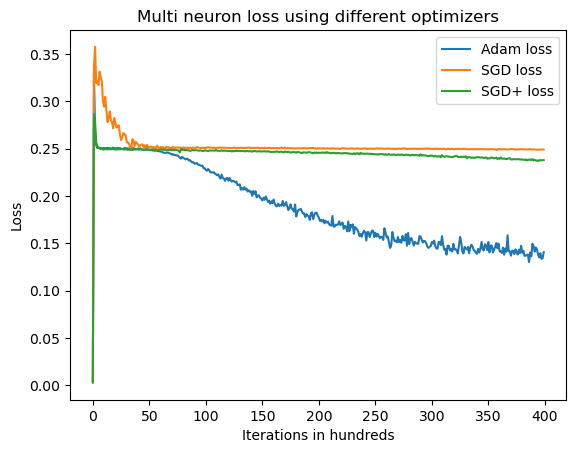

In [6]:
loss3 = cgp2.run_training_loop_multi_neuron_model(training_data2,0.9,0.99)
plt.plot(loss3,label = "Adam loss")


loss1 = cgp1.run_training_loop_multi_neuron_model(training_data1)
plt.plot(loss1,label = "SGD loss")

loss2 = cgp1.run_training_loop_multi_neuron_model(training_data1,0.9,True)
plt.plot(loss2,label = "SGD+ loss")



plt.xlabel("Iterations in hundreds")
plt.ylabel("Loss")
plt.title("Multi neuron loss using different optimizers")

plt.legend(loc = "upper right")